In [1]:
import numpy as np
import time

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
device = 'cuda'

In [4]:
emails = np.loadtxt('Fake email2.txt',dtype='object')

In [5]:
for i in range(20,30):
    print(emails[i])
print('.\n.\n.')
print(emails.shape)
print(type(emails))

guialbu@comcast.net
sjmuir@gmail.com
iapetus@att.net
iamcal@yahoo.ca
fraser@yahoo.ca
bryam@gmail.com
mastinfo@yahoo.com
marioph@aol.com
bowmanbs@hotmail.com
mhanoh@hotmail.com
.
.
.
(5000,)
<class 'numpy.ndarray'>


In [16]:
alphabets = {'.':0,'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,'o':15,'p':16,'q':17,
            'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26,'1':27,'2':28,'3':29,'4':30,'5':31,'6':32,'7':33,
             '8':34,'9':35,'0':36,'@':37,'-':38,'#':39,'$':40,';':41}

In [17]:
rev_alphabets={}
for i in alphabets:
    rev_alphabets[alphabets[i]] = i

rev_alphabets

{0: '.',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: '1',
 28: '2',
 29: '3',
 30: '4',
 31: '5',
 32: '6',
 33: '7',
 34: '8',
 35: '9',
 36: '0',
 37: '@',
 38: '-',
 39: '#',
 40: '$',
 41: ';'}

In [ ]:
input_size = output_size = len(alphabets)
hidden_size = 64
num_layers = 2
learning_rate = 0.001
num_epochs = 10

In [21]:
def encodings(word,alphabets):
    op_word = word[1:] + ';'
    l = len(word)
    ip_word_enc = torch.zeros([l,input_size])
    op_word_enc = torch.zeros([l],dtype=torch.long)
    
    for i in range(l):
        ip_word_enc[i,alphabets[word[i]]] = 1
        op_word_enc[i] = alphabets[op_word[i]]
    return(ip_word_enc,op_word_enc)

In [22]:
a,b = encodings(emails[0].lower(),alphabets)
b

tensor([ 1, 19,  1, 18,  9, 21, 19, 37, 13, 19, 14,  0,  3, 15, 13, 41])

In [23]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(RNN,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,hidden_size,batch_first=True,num_layers=self.num_layers)
        self.fc = nn.Linear(hidden_size,output_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,input,hidden,cell):
        output,(hidden,cell) = self.lstm(input,(hidden,cell))
        output = self.fc(output)
        output = self.dropout(output)
        return(output,(hidden,cell))
    
    def initHidden(self):
        return torch.zeros([self.num_layers,1,self.hidden_size])

In [24]:

model = RNN(input_size,hidden_size,num_layers,output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)


In [26]:
loss_list = []
for i in range(num_epochs):
    t1 = time.time()
    loss_list1 = []
    for word in emails :
        ip_word_enc, op_word_enc = encodings(word.lower(),alphabets)
        
        ip_word_enc = ip_word_enc.reshape([1,ip_word_enc.shape[0],ip_word_enc.shape[1]])
        #op_word_enc = op_word_enc.reshape([1,op_word_enc.shape[0],op_word_enc.shape[1]])

        ip_word_enc = ip_word_enc.to(device)
        op_word_enc = op_word_enc.to(device)

        #print(ip_word_enc.shape)
        model.zero_grad()
        optimizer.zero_grad()

        hidden = model.initHidden().to(device)
        cell = model.initHidden().to(device)
        out,(hidden,cell) = model(ip_word_enc,hidden,cell)
        out = out.reshape(-1,output_size)
        #print(out.shape)
        loss = criterion(out,op_word_enc)
        loss_list1.append(loss.item())
        loss.backward()
        optimizer.step()
    t2 = time.time()
    print("epoch_loss :",np.mean(loss_list1)," |  time :",t2-t1,"sec")
    loss_list += loss_list1

epoch_loss : 1.7768913204193115  |  time : 46.19256091117859 sec
epoch_loss : 1.1712160156965257  |  time : 41.30666661262512 sec
epoch_loss : 1.0722222875714302  |  time : 38.797935485839844 sec
epoch_loss : 0.9540659557521344  |  time : 39.08467745780945 sec
epoch_loss : 0.8364238675951958  |  time : 38.132993936538696 sec
epoch_loss : 0.7316077216356993  |  time : 40.714850664138794 sec
epoch_loss : 0.6473572409510613  |  time : 38.84270095825195 sec
epoch_loss : 0.5880343966037035  |  time : 38.128758668899536 sec
epoch_loss : 0.5440599916398525  |  time : 39.25061631202698 sec


KeyboardInterrupt: 

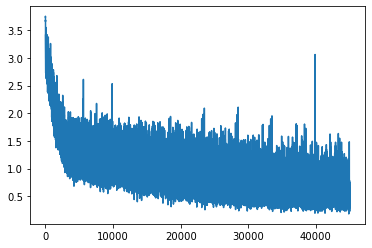

In [27]:
plt.plot(loss_list)

In [28]:
torch.save(model.state_dict(),'CharLevelRNN_LSTM_emails.pth')

### Loading model

In [29]:

model.load_state_dict(torch.load('CharLevelRNN_LSTM_emails.pth'))
model.eval()

RNN(
  (lstm): LSTM(27, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=27, bias=True)
)

### Sampling


In [32]:
def generate(a):

    a_enc = torch.zeros([1,1,input_size]).to(device)

    a_enc[0,0,alphabets[a]] = 1
    hidden = model.initHidden().to(device)
    cell = model.initHidden().to(device)
    output,(hidden,cell) = model(a_enc,hidden,cell)
    #print(output)
    letter = rev_alphabets[torch.argmax(output).item()]
    output = torch.zeros(1,1,input_size).to(device)
    output[0,0,alphabets[letter]] = 1
    #output = F.softmax(output,dim=-1)
    #print(output)
    a += letter
    
    while letter!=';':
        #print(output)
        output,(hidden,cell) = model(output,hidden,cell)
        
        letter = rev_alphabets[torch.argmax(output).item()]
        #output = F.softmax(output,dim=-1)
        output = torch.zeros(1,1,input_size).to(device)
        output[0,0,alphabets[letter]] = 1
        a += letter
        
    return(a)

In [34]:
for i in alphabets:
    if i==';' or i.isdigit() or i=='#' or i=='$':
        continue
    word = generate(i)
    print("for {} : {}".format(i,word))

for . : .hottcoollkzebaebeob@optonline.net;
for a : andrewik@msn.com;
for b : bartlett@me.com;
for c : chronos@msn.com;
for d : denton@optonline.net;
for e : evans@msn.com;
for f : frode@aol.com;
for g : grossman@msn.com;
for h : hellfire@me.com;
for i : isaacson@yahoo.ca;
for j : joelw@me.com;
for k : konit@gmail.com;
for l : leviathan@yahoo.ca;
for m : martink@msn.com;
for n : nasor@yahoo.ca;
for o : oechslin@msn.com;
for p : parksh@me.com;
for q : quinn@gmail.com;
for r : ramollin@msn.com;
for s : starstuff@me.com;
for t : tromey@msn.com;
for u : uncled@outlook.com;
for v : violinhi@gmail.com;
for w : william@msn.com;
for x : xtang@msn.com;
for y : yangyan@me.com;
for z : zilla@optonline.net;
for @ : @sbcglobal.net;
for - : -aveler@me.com;


TypeError: forward() missing 1 required positional argument: 'cell'